In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "~/Downloads/part-00000-8930e765-249c-44ed-b87a-74882688aedb-c000.gz.parquet"

In [3]:
data = pd.read_parquet(path, engine='pyarrow')

In [4]:
data.shape

(12691, 104)

In [5]:
print(' | '.join(data.columns)) 

sumPCII1M | avgPCII1M | totalSpendBeforeDiscount1M | totalSpendBeforeCoupon1M | numberOrders1M | numberItems1M | numberReturnedItems1M | avgNumberItems1M | gmvReturnedItems1M | gmvDiscount1M | gmvWithCoupon1M | numberOrdersWithCoupon1M | sumPCII3M | avgPCII3M | totalSpendBeforeDiscount3M | totalSpendBeforeCoupon3M | numberOrders3M | numberItems3M | numberReturnedItems3M | avgNumberItems3M | gmvReturnedItems3M | gmvDiscount3M | gmvWithCoupon3M | numberOrdersWithCoupon3M | sumPCII6M | avgPCII6M | totalSpendBeforeDiscount6M | totalSpendBeforeCoupon6M | numberOrders6M | numberItems6M | numberReturnedItems6M | avgNumberItems6M | gmvReturnedItems6M | gmvDiscount6M | gmvWithCoupon6M | numberOrdersWithCoupon6M | sumPCII12M | avgPCII12M | totalSpendBeforeDiscount12M | totalSpendBeforeCoupon12M | numberOrders12M | numberItems12M | numberReturnedItems12M | avgNumberItems12M | gmvReturnedItems12M | gmvDiscount12M | gmvWithCoupon12M | numberOrdersWithCoupon12M | sumPCIIQ1 | avgPCIIQ1 | totalSpendBe

In [6]:
len(data['customerHash'].unique())

12691

In [7]:
filter_data = data.loc[(data['sumPCIINext3M'] != 0) & (data['sumPCII12M'] != 0)]

In [8]:
filter_data.shape

(3708, 104)

In [9]:
x = filter_data['sumPCII12M']
y = filter_data['sumPCIINext3M']

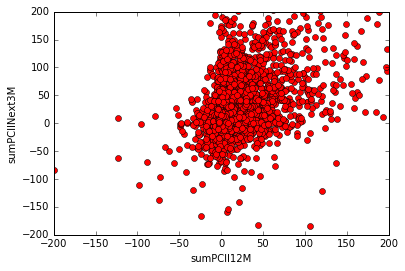

In [10]:
plt.plot(x/4, y, 'ro')
plt.axis([-200, 200, -200, 200])
plt.xlabel('sumPCII12M')
plt.ylabel('sumPCIINext3M')
plt.show()

In [11]:
residual = x/4 - y

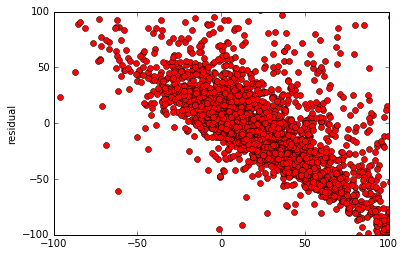

In [12]:
plt.plot(y, residual, 'ro')
plt.axis([-100, 100, -100, 100])
plt.ylabel('residual')
plt.show()

In [14]:
import statsmodels.api as sm

## let's add an intercept (beta_0) to our model
x = sm.add_constant(x)

# Note the difference in argument order
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sumPCIINext3M   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     1827.
Date:                Mon, 08 Oct 2018   Prob (F-statistic):               0.00
Time:                        17:18:45   Log-Likelihood:                -20379.
No. Observations:                3708   AIC:                         4.076e+04
Df Residuals:                    3706   BIC:                         4.077e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6685      1.052     13.942      0.000      12.606      16.731
sumPCII12M     0.2184      0.005     42.738      0.000       0.208       0.228
==============================================================================
Omnibus:                     3150.162   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           247330.386
Skew:                           3.588   Prob(JB):                         0.00
Kurtosis:                      42.362   Cond. No.                         224.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(y, predictions))

58.97274995810485

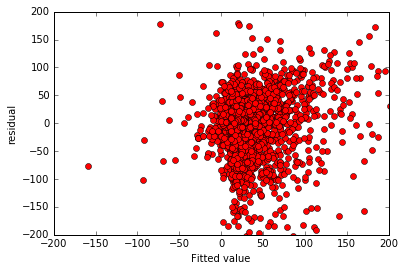

In [19]:
residual = predictions - y

plt.plot(predictions, residual, 'ro')
plt.axis([-200, 200, -200, 200])
plt.xlabel('Fitted value')
plt.ylabel('residual')
plt.show()